In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory 

In [2]:
## Get Directories
dir = r'./autism_dataset/'
train_dir = os.path.join(dir,'train')
test_dir = os.path.join(dir,'test')
val_dir = os.path.join(dir,'valid')

In [3]:
## Define Image size and Batch size 
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

print(BATCH_SIZE)

32


In [4]:
## Creates datasets
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

valid_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2538 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


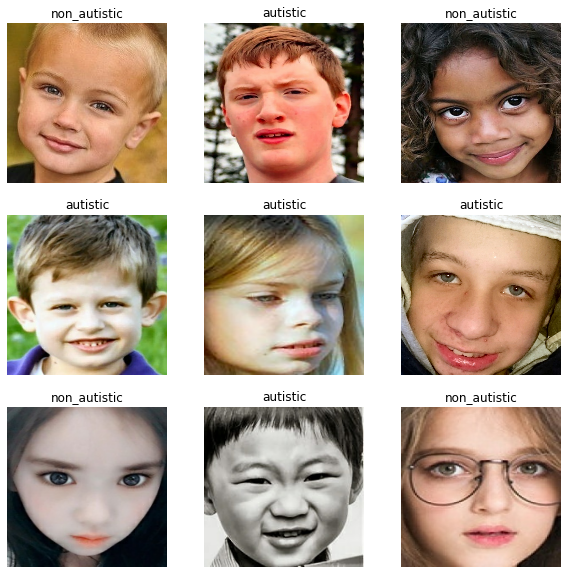

In [5]:
## Show first Classes
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
## Autotune 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
## Create the base model with pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
print(IMG_SHAPE)

(160, 160, 3)


In [8]:
 ## Feature Extraction

In [9]:
## freeze pre-trained model weights 
base_model.trainable = False

In [10]:
## Normalisation
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [11]:
data_augmentation = tf.keras.Sequential([
    #augmentation
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [12]:
## Add classification head
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [13]:
## Add prediction Layer 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [14]:
# Model creation
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
## Compile 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [17]:
## Train Model with validation dataset
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_dataset)

7/7 [==============================] - 16s 2s/step - loss: 1.1815 - accuracy: 0.5300


In [18]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/10
80/80 [==============================] - 184s 2s/step - loss: 0.7481 - accuracy: 0.5961 - val_loss: 0.7495 - val_accuracy: 0.5800
Epoch 2/10
80/80 [==============================] - 222s 3s/step - loss: 0.6723 - accuracy: 0.6332 - val_loss: 0.7046 - val_accuracy: 0.6200
Epoch 3/10
80/80 [==============================] - 439s 6s/step - loss: 0.6397 - accuracy: 0.6438 - val_loss: 0.6767 - val_accuracy: 0.6250
Epoch 4/10
80/80 [==============================] - 50964s 645s/step - loss: 0.6172 - accuracy: 0.6678 - val_loss: 0.6561 - val_accuracy: 0.6350
Epoch 5/10
80/80 [==============================] - 25810s 327s/step - loss: 0.5970 - accuracy: 0.6753 - val_loss: 0.6399 - val_accuracy: 0.6450
Epoch 6/10
80/80 [==============================] - 661s 8s/step - loss: 0.5801 - accuracy: 0.6828 - val_loss: 0.6281 - val_accuracy: 0.6550
Epoch 7/10
80/80 [==============================] - 193s 2s/step - loss: 0.5710 - accuracy: 0.7061 - val_loss: 0.6198 - val_accuracy: 0.6650
Epoch

Mean Validation Accuracy: 0.755468750372529
Mean Training Accuracy:0.7713874168694019
Mean Validation Loss: 0.5370141324542818
Mean Training Loss:0.48809100616545903


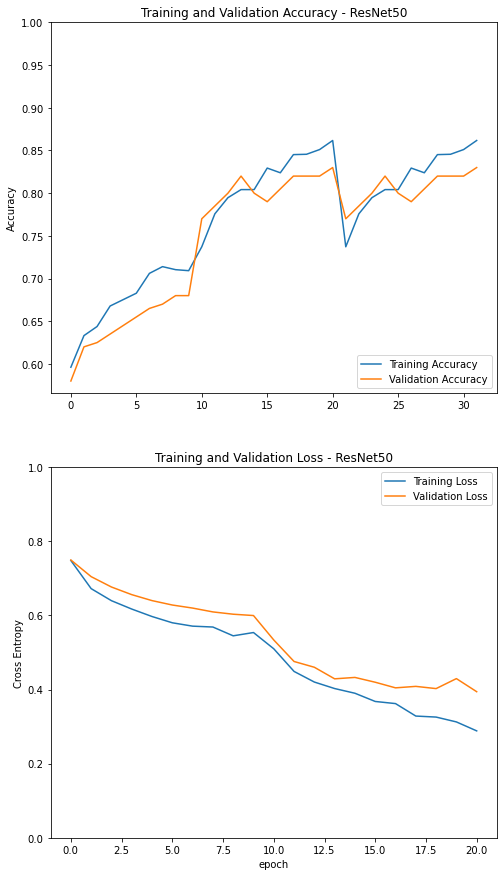

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Means of accuracy
sum_acc = 0
for i in range(len(acc)):
    sum_acc = sum_acc + acc[i]
    acc_mean = sum_acc / len(acc)

sum_val_acc = 0
for i in range(len(val_acc)):
    sum_val_acc = sum_val_acc + val_acc[i]
    val_acc_mean = sum_val_acc / len(val_acc)

print('Mean Validation Accuracy: ' + str(val_acc_mean))
print('Mean Training Accuracy:' + str(acc_mean))

#Means of Loss
sum_loss = 0
for i in range(len(loss)):
    sum_loss = sum_loss + loss[i]
    loss_mean = sum_loss / len(loss)

sum_val_loss = 0
for i in range(len(val_loss)):
    sum_val_loss = sum_val_loss + val_loss[i]
    val_loss_mean = sum_val_loss / len(val_loss)

print('Mean Validation Loss: ' + str(val_loss_mean))
print('Mean Training Loss:' + str(loss_mean))


plt.figure(figsize=(8, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy - ResNet50')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss - ResNet50')
plt.xlabel('epoch')
plt.show()

In [20]:
## Fine Tunning 
base_model.trainable = True ##unfreeze top layers 

In [21]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/Users/brunacoimbra/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [23]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [24]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 10/20
80/80 [==============================] - 413s 5s/step - loss: 0.5100 - accuracy: 0.7372 - val_loss: 0.5337 - val_accuracy: 0.7700
Epoch 11/20
80/80 [==============================] - 1979s 25s/step - loss: 0.4489 - accuracy: 0.7758 - val_loss: 0.4757 - val_accuracy: 0.7850
Epoch 12/20
80/80 [==============================] - 719s 9s/step - loss: 0.4202 - accuracy: 0.7947 - val_loss: 0.4601 - val_accuracy: 0.8000
Epoch 13/20
80/80 [==============================] - 406s 5s/step - loss: 0.4027 - accuracy: 0.8042 - val_loss: 0.4289 - val_accuracy: 0.8200
Epoch 14/20
80/80 [==============================] - 577s 7s/step - loss: 0.3900 - accuracy: 0.8042 - val_loss: 0.4327 - val_accuracy: 0.8000
Epoch 15/20
80/80 [==============================] - 599s 7s/step - loss: 0.3678 - accuracy: 0.8294 - val_loss: 0.4197 - val_accuracy: 0.7900
Epoch 16/20
80/80 [==============================] - 469s 6s/step - loss: 0.3621 - accuracy: 0.8239 - val_loss: 0.4046 - val_accuracy: 0.8050
Epoc

In [31]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

Mean Validation Accuracy: 0.8054545467550104
Mean Training Accuracy:0.8157103007489984
Mean Validation Loss: 0.4354789744723927
Mean Training Loss:0.37791074406016956


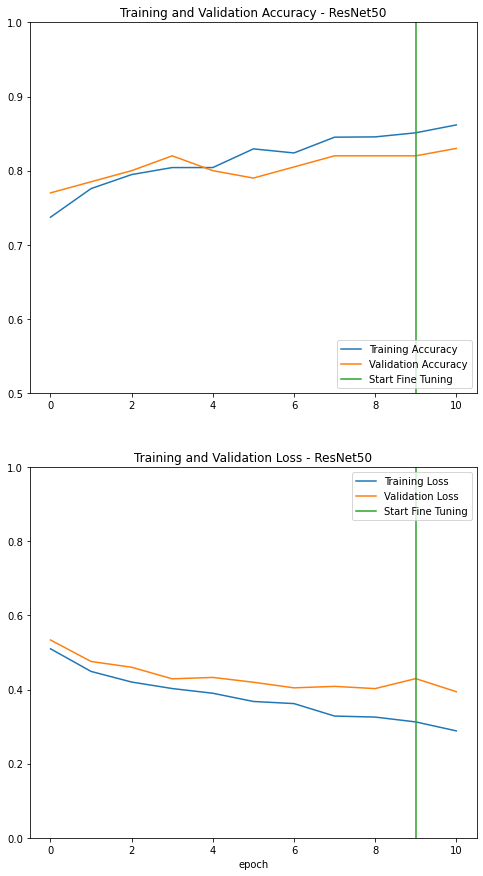

In [32]:
#Means of accuracy
sum_acc = 0
for i in range(len(acc)):
    sum_acc = sum_acc + acc[i]
    acc_mean = sum_acc / len(acc)

sum_val_acc = 0
for i in range(len(val_acc)):
    sum_val_acc = sum_val_acc + val_acc[i]
    val_acc_mean = sum_val_acc / len(val_acc)

print('Mean Validation Accuracy: ' + str(val_acc_mean))
print('Mean Training Accuracy:' + str(acc_mean))

#Means of Loss
sum_loss = 0
for i in range(len(loss)):
    sum_loss = sum_loss + loss[i]
    loss_mean = sum_loss / len(loss)

sum_val_loss = 0
for i in range(len(val_loss)):
    sum_val_loss = sum_val_loss + val_loss[i]
    val_loss_mean = sum_val_loss / len(val_loss)

print('Mean Validation Loss: ' + str(val_loss_mean))
print('Mean Training Loss:' + str(loss_mean))



plt.figure(figsize=(8, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - ResNet50')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - ResNet50')
plt.xlabel('epoch')
plt.show()

In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 26s 4s/step - loss: 0.2727 - accuracy: 0.8750
Test accuracy : 0.875


Predictions:
 [0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1]
Labels:
 [0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1]


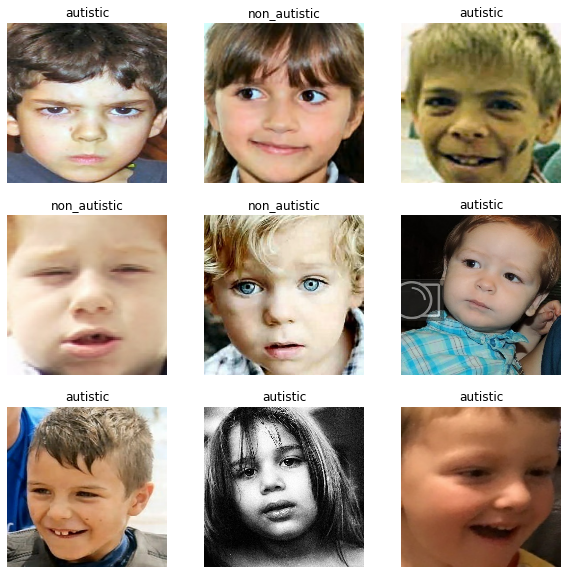

In [28]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")